# Symbolic regression approximation based on GA for DFT exchange-correlation functional from neural net

В данном ноутбуке решается задача символьной регрессии для предсказания аналитического вида уравнений для обменно-корреляционного потенциала LDA, сгенерированного нейросетью из работы https://github.com/ml-electron-project/NNfunctional/tree/master. Данные, с которыми мы работали, были сгенерированы в ноутбуке "Генерация нейросетевого потенциала". Они представляют из себя зависимость Exc = f(ρ) полученную из расчета энергии молекулы  методом DFT с использованием указанного нейросетевого функционала.


In [ ]:
!pip install -q gplearn
from sympy import *

import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from gplearn.genetic import SymbolicTransformer
from sklearn.utils import check_random_state
from gplearn.functions import make_function

import sklearn

import matplotlib
from matplotlib import pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

Для успешной аппроксимации необходимо добавить базисные функции

In [ ]:
#Function for appending basic function in functions set for approximations
def add_func(func_names, funcs):
  global function_set
  for i in range(len(funcs)):

    func_name = func_names[i]
    func = funcs[i]
    function = make_function(function=func, name=func_name, arity=1)

    function_set.append(function)

In [ ]:
function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv']

In [ ]:
#Make some custom basic functions
def square(x):
  return x**2

def pow3(x):
  return x**3

def exp(x):
  return np.exp(x)

def neg(x):
  return -x

def sub(x, y):
  return x - y

def add(x, y):
  return x+y

def inv(x):
  return 1/x

def scuare(x):
  return x**2

def div(x, y):
  return x/y

def mul(x, y):
  return x*y

def cbrt(x):
  return np.cbrt(x)

def pow4_3(x):
  return x*np.cbrt(x)


In [ ]:
converter = {
    'sub': lambda x, y : x - y,
    'div': lambda x, y : x/y,
    'mul': lambda x, y : x*y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : -x,
    'pow': lambda x, y : x**y,
    'sin': lambda x    : sin(x),
    'cos': lambda x    : cos(x),
    'inv': lambda x: 1/x,
    'sqrt': lambda x: x**0.5,
    'pow3': lambda x: x**3
}

In [ ]:
add_func(['cbrt', 'exp', 'pow3', 'scuare', 'pow4_3'], [cbrt, exp, pow3, scuare, pow4_3])

In [ ]:
function_set

['add',
 'sub',
 'mul',
 'div',
 'sqrt',
 'log',
 'abs',
 'neg',
 'inv',

In [ ]:
from sympy.abc import x
from sympy import cse, sqrt, sin, pprint

In [ ]:
def cbrt(x):
  return x**(1/3)

Импортируем датасет состоящий из значений плотности электронов и соответусвующих им значений обменно-корреляционной энергии

In [ ]:
#Reciave data with Exc(LDA) = f(rho), where f() is MLP
df = pd.read_csv('/content/NN_functional.csv')
table_init = df.copy()

table = table_init[0:5000]
table_test = table_init[5000:10000]

rho_train, exc_train, rho_test, exc_test = table['x_0'].values, table['y'].values, table_test['x_0'].values, table_test['y'].values

In [ ]:
np.shape(rho_train), np.shape(rho_test)

((5000,), (5000,))

Следующая функция подбирает нелинейные преобразования над фичой

In [ ]:
gp = SymbolicTransformer(generations=2, population_size=5000,
                         hall_of_fame=20, n_components=1,
                         function_set=function_set,
                         parsimony_coefficient=0.001,
                         max_samples=0.9, verbose=1,
                         random_state=0)
gp.fit(rho_train.reshape(-1, 1), exc_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.66         0.434966        5         0.999774          0.99978     17.84s
   1     7.35         0.800843        9         0.999941         0.999937      0.00s


SymbolicTransformer(function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                  'abs', 'neg', 'inv',
                                  <gplearn.functions._Function object at 0x7bed8ee36f80>,
                                  <gplearn.functions._Function object at 0x7bed8ee371c0>,
                                  <gplearn.functions._Function object at 0x7bed8ee36800>,
                                  <gplearn.functions._Function object at 0x7bed8ee37010>,
                                  <gplearn.functions._Function object at 0x7bed8ee37d30>],
                    generations=2, hall_of_fame=20, max_samples=0.9,
                    n_components=1, population_size=5000, random_state=0,
                    verbose=1)

После нелинейных преобразований составим линейную модель чтобы определить константы



Text(0, 0.5, 'predicted')

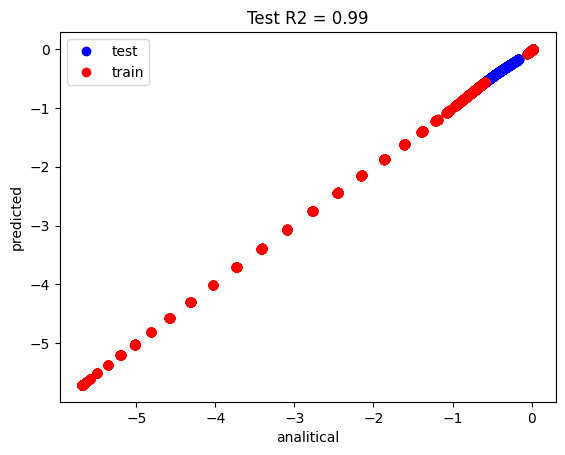

In [ ]:
#Make over our feature founded non-linear transformation and after make linear model with transformed feature
gp_features = gp.transform(rho_train.reshape(-1, 1))
new_X = pd.DataFrame(gp_features)

est = LinearRegression()
est.fit(new_X, exc_train)
plt.title('Test R2 = '+str(sklearn.metrics.r2_score(exc_test, est.predict(gp.transform(rho_test.reshape(-1, 1)))).round(3)))

#Check pair plot
ax = ([plt.plot(est.predict(gp.transform(rho_test.reshape(-1, 1))), exc_test, 'ro', color='b'),
       plt.plot(est.predict(gp.transform(rho_train.reshape(-1, 1))), exc_train, 'ro')]),
plt.legend(['test', 'train'])
plt.xlabel('analitical')
plt.ylabel('predicted')


Извлечем полученный функционал из SymbolicTransformer и коэффициентов линейной регрессии

In [ ]:
# Reciave our functional form
def approximated_func(x):
  return -0.96033992969024*(x**(1/3)+(1/(x+0.654))**(1/6)) + 1.051513354413

est.coef_[0]*add(cbrt(sqrt(inv(add(x, 0.654)))), cbrt(x)) + est.intercept_

-0.96033992969024*x**0.333333333333333 - 0.96033992969024*(1/(x + 0.654))**0.166666666666667 + 1.051513354413

In [ ]:
def see_similarity2(approx_func, rho_train, exc_train, rho_test, exc_test):

  plt.title('test_R2 = ' + str(sklearn.metrics.r2_score(exc_test, approx_func(rho_test)).round(3)) +
            ',test_RMSE = ' + str((sklearn.metrics.mean_squared_error(exc_test, approx_func(rho_test))*0.5).round(6))+
            '\nrain_R2 = ' + str(sklearn.metrics.r2_score(exc_train, approx_func(rho_train)).round(3)) +
            ',train_RMSE = ' + str((sklearn.metrics.mean_squared_error(exc_train, approx_func(rho_train))*0.5).round(6)))

  ax = ([plt.plot(rho_train, exc_train, 'ro'), plt.plot(rho_test, exc_test, 'ro', color='blue'),
        plt.plot(rho_train, approx_func(rho_train), 'ro', color='green'), plt.plot(rho_test, approx_func(rho_test), '--', color='green')])
  plt.xlabel('rho')
  plt.ylabel('energy')
  plt.legend(['train', 'test', 'approximation'])


Посмотрим как аппроксимирующий функционал соотносится с нейросетевым функционалом

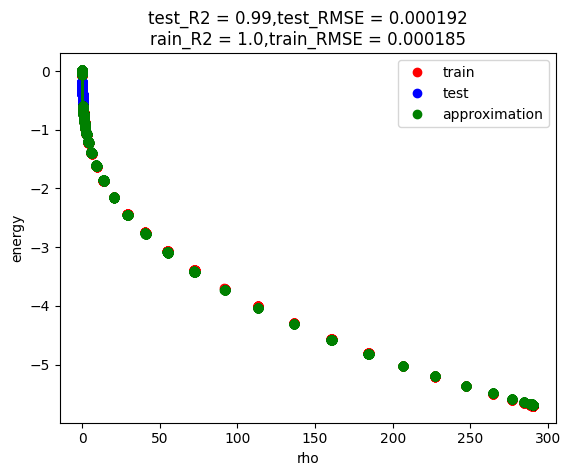

In [ ]:
see_similarity2(approximated_func, rho_train, exc_train, rho_test, exc_test)